In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
from os import path
import yaml

Read in the data from the base / "from-scratch" knee models, take the average of metrics across folds, and get it down to a dataframe that just has dice coefficients for the best performing version of each model architecture.

In [2]:
base = pd.read_csv(path.join("..", "from_arc", "knee_base_cv.csv"))
base = base[[
    "label", "version", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
base = base.groupby(["label", "version"]).mean().drop(columns=["fold"])
base = base[
    base.groupby(["label"])["metrics_val_dsc_0_epoch_final"].transform(max) 
    == base["metrics_val_dsc_0_epoch_final"]
].dropna()
base = base.reset_index()

base["label"] = base["label"].apply(lambda x: x[0:-16])

labels_renaming = {
    "unet": "UNet",
    "unetpp": "UNet++",
    "unetr": "UNETR",
    "segresnetvae": "SegResNetVAE",
    "segan": "SeGAN"
}
base = base.replace({"label": labels_renaming})

base = base.rename(
    columns = {
        "metrics_val_dsc_0_epoch_final": "cort DSC",
        "metrics_val_dsc_1_epoch_final": "trab DSC",
        "metrics_val_dsc_2_epoch_final": "back DSC"
    }
)

base

,label,version,cort DSC,trab DSC,back DSC
0,SeGAN,21100349,0.866667,0.974689,0.980413
1,SegResNetVAE,21100369,0.630039,0.879377,0.799843
2,UNet,21100397,0.797375,0.953737,0.967423
3,UNet++,21100408,0.831101,0.973065,0.983647
4,UNETR,21100414,0.813753,0.959312,0.958588


Read in the knee models trained using transfer learning, take the average of metrics across folds.

In [3]:
transfer = pd.read_csv(path.join("..", "from_arc", "knee_transfer_cv.csv"))
transfer = transfer[[
    "label", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
transfer = transfer.groupby(["label"]).mean().drop(columns=["fold"])
transfer = transfer.reset_index()

transfer["label"] = transfer["label"].apply(lambda x: x[0:-20])

transfer = transfer.replace({"label": labels_renaming})

transfer = transfer.rename(
    columns = {
        "metrics_val_dsc_0_epoch_final": "cort DSC",
        "metrics_val_dsc_1_epoch_final": "trab DSC",
        "metrics_val_dsc_2_epoch_final": "back DSC"
    }
)

transfer

,label,cort DSC,trab DSC,back DSC
0,SeGAN,0.854751,0.960095,0.956363
1,SegResNetVAE,0.895600,0.983202,0.988210
2,UNet,0.887526,0.974210,0.984481
3,UNet++,0.900274,0.979068,0.987336
4,UNETR,0.865874,0.971287,0.978959


Add a column to each dataframe that indicates the type of training, and then stack them.

In [4]:
base["training"] = "from-scratch"
transfer["training"] = "transfer"

df = pd.concat([base.drop(columns=["version"]), transfer], ignore_index=True)
df

,label,cort DSC,trab DSC,back DSC,training
0,SeGAN,0.866667,0.974689,0.980413,from-scratch
1,SegResNetVAE,0.630039,0.879377,0.799843,from-scratch
2,UNet,0.797375,0.953737,0.967423,from-scratch
3,UNet++,0.831101,0.973065,0.983647,from-scratch
4,UNETR,0.813753,0.959312,0.958588,from-scratch
5,SeGAN,0.854751,0.960095,0.956363,transfer
6,SegResNetVAE,0.895600,0.983202,0.988210,transfer
7,UNet,0.887526,0.974210,0.984481,transfer
8,UNet++,0.900274,0.979068,0.987336,transfer
9,UNETR,0.865874,0.971287,0.978959,transfer


Now we can generate a bar plot to compare the models for how they predict each mask:

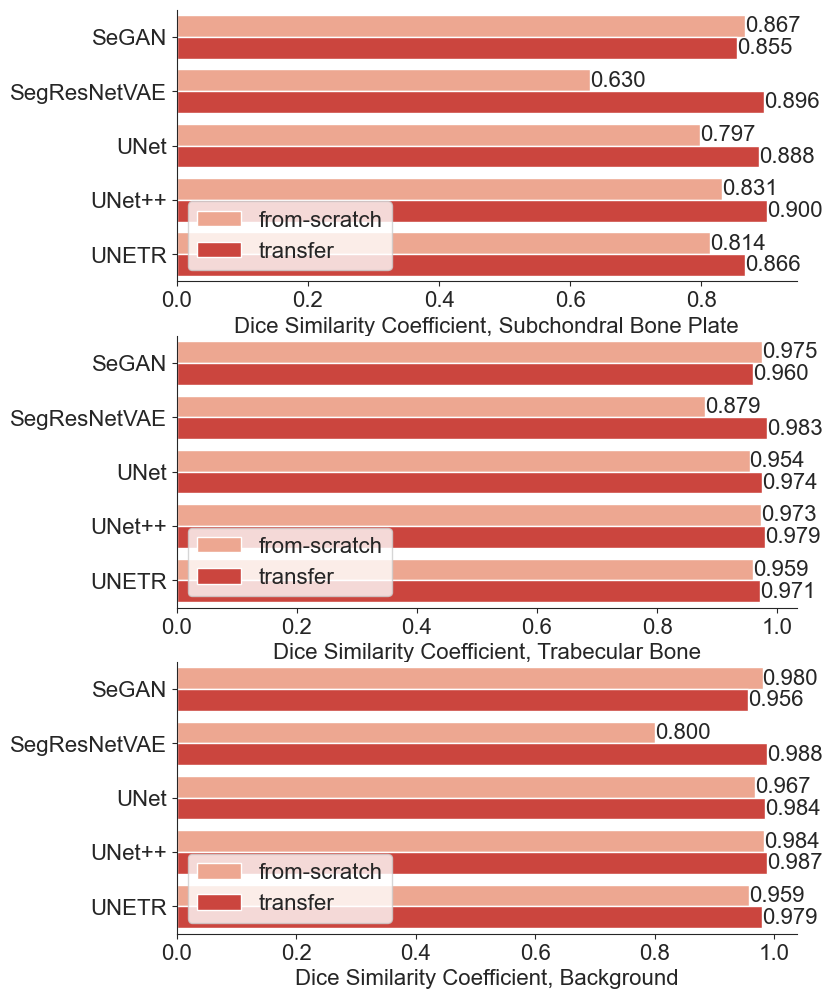

In [68]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Arial',
      'font.size' : 16}
plt.rcParams.update(rc)

metrics = {
    "cort DSC": "Dice Similarity Coefficient, Subchondral Bone Plate", 
    "trab DSC": "Dice Similarity Coefficient, Trabecular Bone", 
    "back DSC": "Dice Similarity Coefficient, Background"
}

fig, axs = plt.subplots(3,1,figsize=(8,12))

for metric, ax in zip(metrics, axs):

    ax = sns.barplot(ax=ax, data=df, y="label", x=metric, hue="training", palette="Reds")
    #ax.legend_.remove()
    ax.legend(loc="lower left")
    
    ax.set(
        ylabel="",
        xlabel=metrics[metric]
    )

    for i in ax.containers:
        ax.bar_label(i, fmt="%0.3f")

    ax.grid(axis="x")
    sns.despine()

#ax.legend(loc="lower left")

plt.show()

There seems to be a tie in performance between the `SegResNetVAE` and the `UNet++`, each trained by transfer learning. We can transfer these models from ARC and show some visual examples (but not in this notebook, because I can't load checkpoints in jupyter notebooks for some reason).

Let's verify that for both of these models, we trained them for a sufficient period of time and they could not be made more accurate with longer training (more epochs and/or hours):

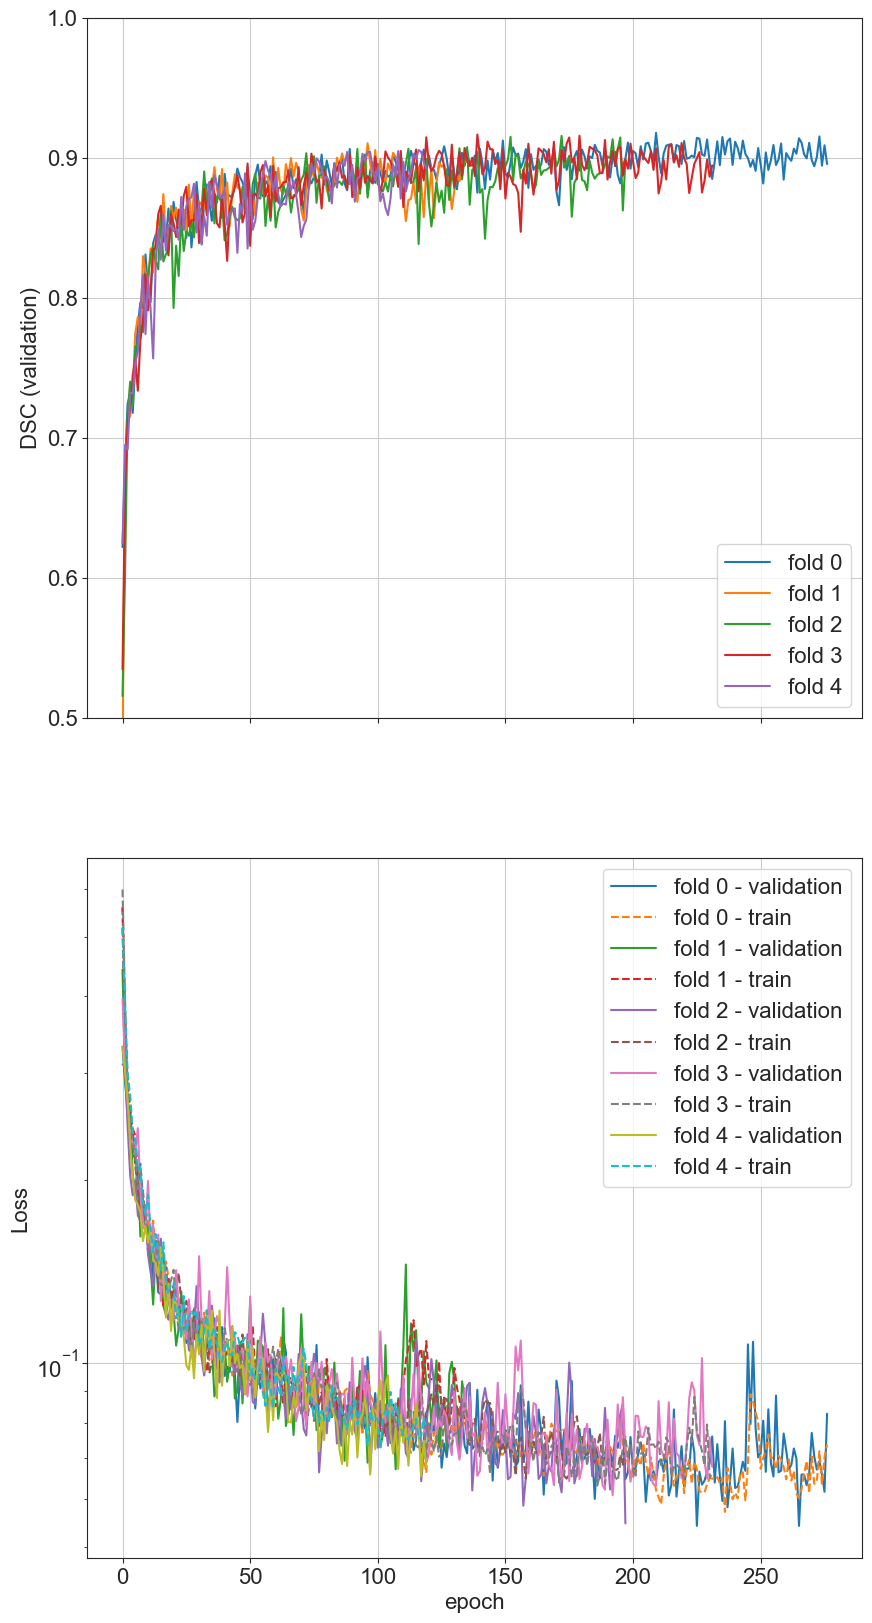

In [65]:
segresnetvae_metrics_fns = glob(
    path.join("..", "from_arc", "segresnetvae_3d_knee_transfer_cv", "*_f?", "metrics.csv")
)
segresnetvae_metrics_dfs = [pd.read_csv(fn) for fn in segresnetvae_metrics_fns]

sns.set_style("ticks",{'axes.grid' : True})

fig, axs = plt.subplots(2, 1, figsize=(10,20), sharex=True)


for i, srnv_df in enumerate(segresnetvae_metrics_dfs):
    sns.lineplot(ax=axs[0], data=srnv_df, x="epoch", y="val_dsc_0_epoch", label=f"fold {i}")
    sns.lineplot(ax=axs[1], data=srnv_df, x="epoch", y="val_loss_epoch", linestyle="-", label=f"fold {i} - validation")
    sns.lineplot(ax=axs[1], data=srnv_df, x="epoch", y="train_loss_epoch", linestyle="--", label=f"fold {i} - train")

axs[0].set_ylim(0.5,1)
axs[0].set_ylabel("DSC (validation)")

axs[1].set_yscale("log")
axs[1].set_ylabel("Loss")
    
plt.show()

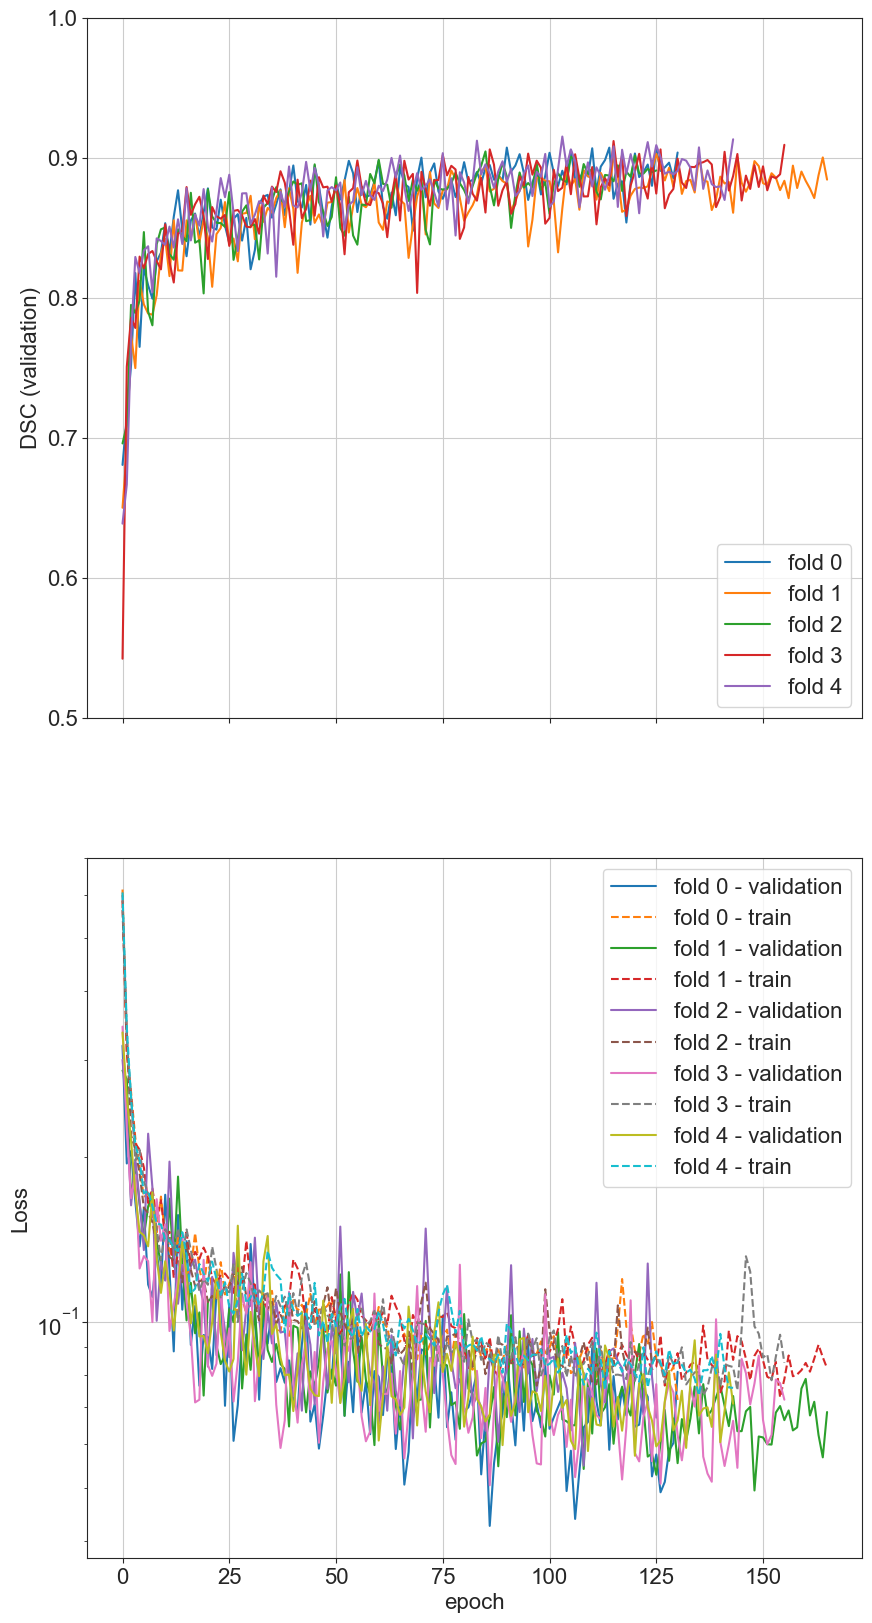

In [66]:
unetpp_metrics_fns = glob(
    path.join("..", "from_arc", "unetpp_3d_knee_transfer_cv", "*_f?", "metrics.csv")
)
unetpp_metrics_dfs = [pd.read_csv(fn) for fn in unetpp_metrics_fns]

sns.set_style("ticks",{'axes.grid' : True})

fig, axs = plt.subplots(2, 1, figsize=(10,20), sharex=True)


for i, upp_df in enumerate(unetpp_metrics_dfs):
    sns.lineplot(ax=axs[0], data=upp_df, x="epoch", y="val_dsc_0_epoch", label=f"fold {i}")
    sns.lineplot(ax=axs[1], data=upp_df, x="epoch", y="val_loss_epoch", linestyle="-", label=f"fold {i} - validation")
    sns.lineplot(ax=axs[1], data=upp_df, x="epoch", y="train_loss_epoch", linestyle="--", label=f"fold {i} - train")

axs[0].set_ylim(0.5,1)
axs[0].set_ylabel("DSC (validation)")

axs[1].set_yscale("log")
axs[1].set_ylabel("Loss")
    
plt.show()